In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
while '/home/ashesh.ashesh/code/Disentangle' in sys.path:
    sys.path.remove('/home/ashesh.ashesh/code/Disentangle')
sys.path.append('/home/ashesh.ashesh/code/ekin/ekin_denoiSplit/')

In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [4]:
# there are two environments(debug and prod). From where you want to fetch the code and data? 
DEBUG=False

In [5]:
%run ./nb_core/root_dirs_ekin.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /media/lsdf02_VV/Ekin/Projects/ExM/VitalSynthEx/Data/forDivnoise/usplit
CODE_ROOT:	 /home/spock/Documents/


/home/spock/Documents/ekin/miniforge3/envs/usplit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
ckpt_dir = "/home/spock/Documents/ekin/training/2403/D26-M29-S0-L0/6"

In [7]:
from denoisplit.data_loader.multifile_raw_dloader import SubDsetType


image_size_for_grid_centers = 32
mmse_count = 5
custom_image_size = 128

# subdset_type = SubDsetType.OneChannel
subdset_type = None
eval_datasplit_type = DataSplitType.Test

enable_calibration =False
calibration_factor_fpath = './calibration_factor.npy'
# the prediction will be saved here.
prediction_output_fpath = './prediction_output/'


batch_size = 16
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [8]:
%run ./nb_core/config_loader.ipynb

data:
  background_quantile: 0.0
  clip_background_noise_to_zero: false
  clip_percentile: 0.995
  data_type: 26
  deterministic_grid: false
  grid_size: 32
  image_size: 128
  inp_idx: 0
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: false
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  skip_normalization_using_mean: false
  subdset_type: 0
  tar_idx: 1
  target_separate_normalization: true
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 32
datadir: /media/lsdf02_VV/Ekin/Projects/ExM/VitalSynthEx/Data/forDivNoise/usplit/
exptname: 2403/D26-M29-S0-L0/6
git:
  branch: main
  changedFiles:
  - denoisplit/configs/hdn_translation_config.py
  - denoisplit/notebooks/EvalOnMultiFileDatasetEkin.ipynb
  latest_commit: 365013b77b48821f30af7c0a5597b031ca8116ce
  untracked_files: []
hostname: terminalserver
loss:
  free_bits: 1.0
  kl_annealing: false
  kl_annealtime: 10
  kl_loss_formulation: ''
  kl_min: 

In [9]:
config.model

analytical_kl: false
decoder:
  batchnorm: true
  blocks_per_layer: 1
  conv2d_bias: true
  dropout: 0.1
  multiscale_retain_spatial_dims: false
  n_filters: 64
  res_block_kernel: 3
  res_block_skip_padding: false
enable_noise_model: false
encoder:
  batchnorm: true
  blocks_per_layer: 1
  dropout: 0.1
  n_filters: 64
  res_block_kernel: 3
  res_block_skip_padding: false
gated: true
img_shape: null
learn_top_prior: true
logvar_lowerbound: -5
merge_type: residual
mode_pred: true
model_type: 29
monitor: val_psnr
multiscale_lowres_separate_branch: false
multiscale_retain_spatial_dims: true
no_initial_downscaling: true
noise_model_ch1_fpath: null
non_stochastic_version: false
nonlin: elu
predict_logvar: null
res_block_type: bacdbacd
skip_nboundary_pixels_from_loss: null
stochastic_skip: true
use_vampprior: false
var_clip_max: 20
z_dims:
- 128
- 128
- 128
- 128

In [10]:
if subdset_type is not None:
    config.data.subdset_type = subdset_type


In [11]:
# config.model.decoder

In [12]:
from denoisplit.core.sampler_type import SamplerType
from denoisplit.core.loss_type import LossType
# from denoisplit.core.lowres_merge_type import LowresMergeType
from denoisplit.data_loader.multifile_raw_dloader import SubDsetType

with config.unlocked():
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if config.data.data_type == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.Iba1Ki64
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
    
    if config.data.data_type == DataType.TwoDset:
        config.model.model_type = ModelType.LadderVae
        for key in config.data.dset1:
            config.data[key] = config.data.dset1[key]
    if config.data.data_type == DataType.TavernaSox2GolgiV2:
        config.data.channel_1 = '555-647'
        config.data.channel_2 = '555-647'


In [13]:
dtype = config.data.data_type

In [14]:
if DEBUG:
    if dtype == DataType.CustomSinosoid:
        data_dir = f'{DATA_ROOT}/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
else:
    if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
    elif dtype == DataType.Prevedel_EMBL:
        data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
    elif dtype == DataType.AllenCellMito:
        data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
    elif dtype == DataType.SeparateTiffData:
        data_dir = f'{DATA_ROOT}/ventura_gigascience'
    elif dtype == DataType.SemiSupBloodVesselsEMBL:
        data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
    elif dtype == DataType.Pavia2VanillaSplitting:
        data_dir = f'{DATA_ROOT}/pavia2'
    elif dtype == DataType.ExpansionMicroscopyMitoTub:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
    elif dtype == DataType.ShroffMitoEr:
        data_dir = f'{DATA_ROOT}/shrofflab/'
    elif dtype == DataType.HTIba1Ki67:
        data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
    elif dtype == DataType.BioSR_MRC:
        data_dir = f'{DATA_ROOT}/BioSR/'
    elif dtype == DataType.TavernaSox2Golgi:
        data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/'
    elif dtype == DataType.ExpMicroscopyV2:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/'
    elif dtype == DataType.TavernaSox2GolgiV2:
        data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
    elif dtype == DataType.TumorHighRes:
        data_dir = f'{DATA_ROOT}/'
        
#     2720*2720: microscopy dataset.


In [15]:
%run ./nb_core/disentangle_setup.ipynb


Loaded from TwoChannel /media/lsdf02_VV/Ekin/Projects/ExM/VitalSynthEx/Data/forDivnoise/usplit/ 320

[SingleFileDset] Sz:128 Train:1 N:1 NumPatchPerN:1024 NormInp:False SingleNorm:True Rot:False RandCrop:True Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
MultiFileDset avg height: 1024, avg width: 1024, count: 320
Loaded from TwoChannel /media/lsdf02_VV/Ekin/Projects/ExM/VitalSynthEx/Data/forDivnoise/usplit/ 40

[SingleFileDset] Sz:128 Train:0 N:1 NumPatchPerN:1024 NormInp:False SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
MultiFileDset avg height: 1024, avg width: 1024, count: 40

ls: cannot access '/home/ashesh.ashesh/training/disentangle/2301/D3-M10-S0-L3/25': No such file or directory
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1

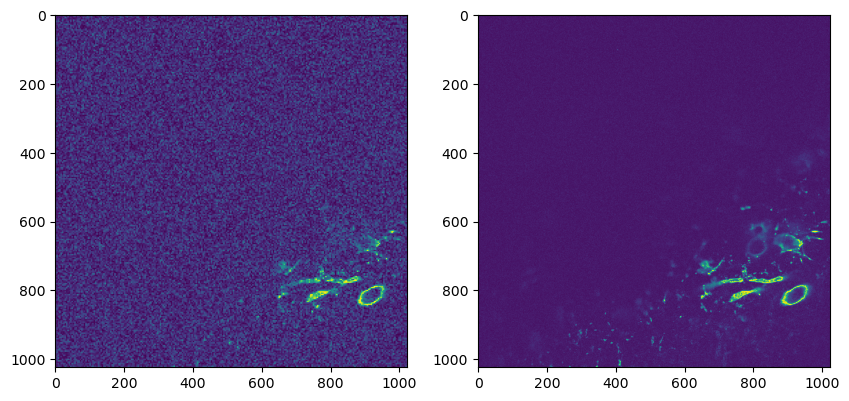

In [16]:
val_dset.dsets[0]._data.shape
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(val_dset.dsets[0]._data[0,...,0])
ax[1].imshow(val_dset.dsets[0]._data[0,...,1])

107816


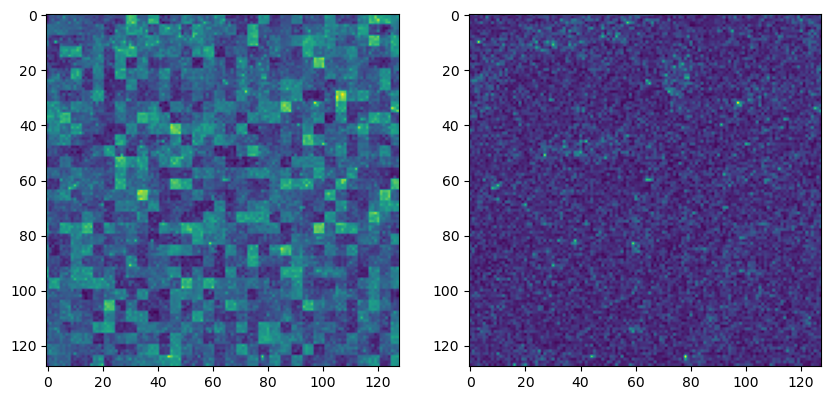

In [17]:
idx = np.random.randint(0, len(train_dset))
print(idx)
inp, tar = train_dset[idx]
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(inp[0])
ax[1].imshow(tar[0])

In [18]:
tar.shape

(1, 128, 128)

In [19]:
len(train_dset)

327680

In [20]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

In [21]:
# if config.model.model_type not in [ModelType.UNet, ModelType.BraveNet]:
#     with torch.no_grad():
#         inp, tar = val_dset[0][:2]
#         out, td_data = model(torch.Tensor(inp[None]).cuda())
#         print(td_data['z'][-1].shape)
#         print(out.shape)

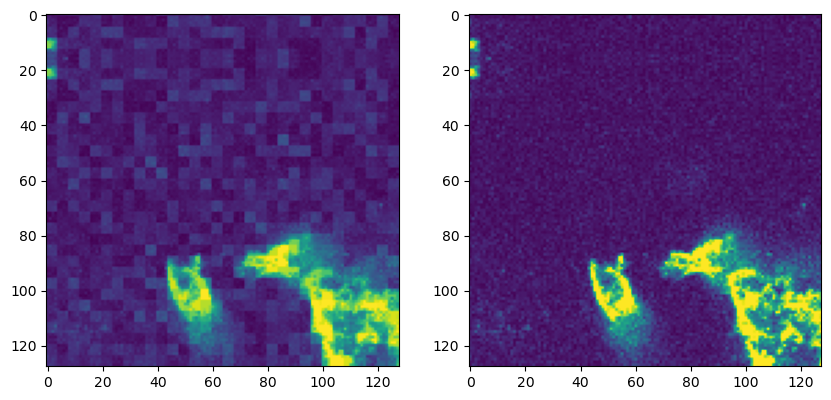

In [22]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = max(len(inp_tmp),3)
nrows = 2
if tar_tmp.shape[0] == 2:
    _,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
    for i in range(len(inp_tmp)):
        ax[0,i].imshow(inp_tmp[i])
    ax[1,1].imshow(tar_tmp[0])
    ax[1,0].imshow(tar_tmp[0]+tar_tmp[1])
    ax[1,2].imshow(tar_tmp[1])
elif tar_tmp.shape[0] == 1:
    _,ax = plt.subplots(figsize=(10,5),ncols=2,nrows=1)
    ax[0].imshow(inp_tmp[0])
    ax[1].imshow(tar_tmp[0])


In [23]:
from denoisplit.analysis.stitch_prediction import stitch_predictions
from denoisplit.analysis.mmse_prediction import get_dset_predictions
# from denoisplit.analysis.stitch_prediction import get_predictions as get_dset_predictions

pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp) )

100%|███████████████████████████████████████| 2560/2560 [10:30<00:00,  4.06it/s]


Patch wise PSNR, as computed during training [27.68] 27.68


In [24]:
from copy import deepcopy
if config.data.data_type == DataType.TavernaSox2GolgiV2:
    dset_is_input = config.data.channel_1 == config.data.channel_2 and config.data.channel_1 == '555-647'
    if dset_is_input:
        new_config = deepcopy(config)
        new_config.data.channel_1 = 'GT_Cy5'
        new_config.data.channel_2 = 'GT_TRITC'
        _, val_dset_target = create_dataset(new_config, data_dir, eval_datasplit_type = eval_datasplit_type)
    else:
        val_dset_target = val_dset
else:
    val_dset_target = val_dset

In [25]:
np.mean(rec_loss)

0.17509434

In [26]:
len(val_dset_target)

40960

In [27]:
print(np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2))

[0.09 0.09 0.17 0.25 0.36 0.42 0.44]


In [28]:
pred_tiled.shape

(40960, 1, 128, 128)

In [29]:
count = 0
for dset in val_dset_target.dsets:
    count += dset.idx_manager.grid_count()

In [30]:
count 

40960

In [31]:
len(pred_tiled)

40960

In [32]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

pred = stitch_predictions(pred_tiled,val_dset, smoothening_pixelcount=0)
pred_std = stitch_predictions(pred_std_tiled,val_dset, smoothening_pixelcount=0)

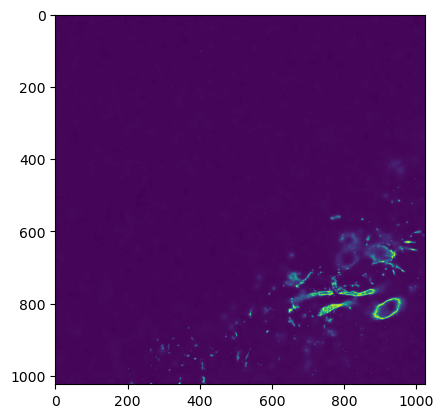

In [33]:
plt.imshow(pred[0][0,...,0])

In [34]:
def get_ignores_pixels(pred_frames):
    ignored_pixels = 1
    while(pred_frames[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    return ignored_pixels

def print_ignored_pixels():
    if isinstance(pred, np.ndarray):
        ignored_pixels = get_ignores_pixels(pred)
    elif isinstance(pred, list):
        ignored_pixels = [get_ignores_pixels(p) for p in pred]

    print(f'Last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = print_ignored_pixels()

Last [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [35]:
print(actual_ignored_pixels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
if isinstance(pred, np.ndarray):
    if config.data.data_type in [DataType.OptiMEM100_014,
                                                        DataType.SemiSupBloodVesselsEMBL, 
                                                        DataType.Pavia2VanillaSplitting,
                                                        DataType.ExpansionMicroscopyMitoTub,
                                                        DataType.ShroffMitoEr,
                                                        DataType.HTIba1Ki67]:
        ignored_last_pixels = 32 
    elif config.data.data_type == DataType.BioSR_MRC:
        ignored_last_pixels = 44
        assert val_dset.get_img_sz() == 64
    else:
        ignored_last_pixels = 0


    assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}'
    print(ignored_last_pixels)
elif isinstance(pred, list):
    ignored_last_pixels = actual_ignored_pixels
ignore_first_pixels = 0

In [37]:
tar = val_dset_target._data if isinstance(pred, np.ndarray) else [val_dset_target.dsets[i]._data for i in range(len(val_dset_target.dsets))]

def ignore_pixels(arr):
    if ignore_first_pixels:
        arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
    if ignored_last_pixels !=0:
        if isinstance(arr, np.ndarray):
            arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
            return arr
        elif isinstance(arr, list):
            output_arr = []
            for i,a in enumerate(arr):
                if ignored_last_pixels[i] !=0:
                    output_arr.append(a[:,:-ignored_last_pixels[i],:-ignored_last_pixels[i]] )
                else:
                    output_arr.append(a)
            return output_arr
        
pred = ignore_pixels(pred)
tar = ignore_pixels(tar)


In [38]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [39]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']
    
sep_mean = sep_mean.squeeze()[None,None,None]
sep_std = sep_std.squeeze()[None,None,None]

if isinstance(pred, np.ndarray):
    tar_normalized = (tar - sep_mean.cpu().numpy())/sep_std.cpu().numpy()
    tar1 =tar_normalized[...,0]
    tar2 =tar_normalized[...,1]
elif isinstance(pred, list):
    assert isinstance(tar, list)
    assert len(pred) == len(tar)
    tar_normalized = [(tar[i]-sep_mean.cpu().numpy())/sep_std.cpu().numpy() for i in range(len(tar))]
    tar1 = [tar_normalized[i][...,0] for i in range(len(tar))]
    tar2 = [tar_normalized[i][...,1] for i in range(len(tar))]

In [40]:
if isinstance(pred, np.ndarray):
    q_vals = [0.01, 0.1,0.5,0.9,0.95, 0.99,1]
    print('Nuc:', np.quantile(tar_normalized[0][...,0], q_vals).round(2))
    print('Tub:', np.quantile(tar_normalized[0][...,1], q_vals).round(2))
    print('Nuc:', np.quantile(tar[0][...,0], q_vals))
    print('Tub:', np.quantile(tar[0][...,1], q_vals))

35
(1, 1024, 1024, 2)


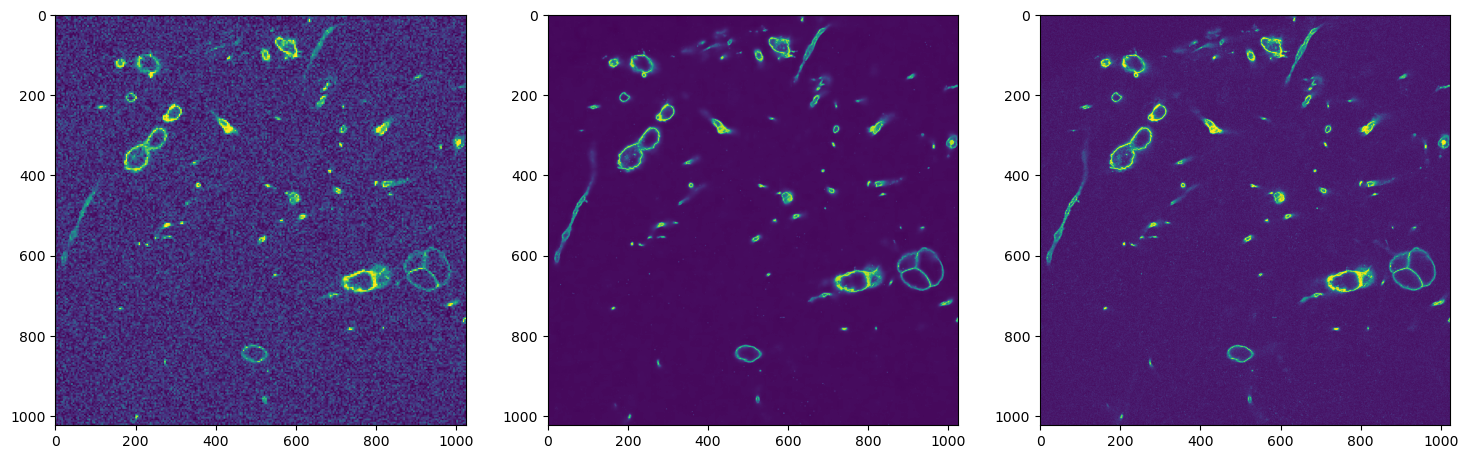

In [41]:
_,ax = plt.subplots(figsize=(18,6),ncols=3)
idx = np.random.randint(len(pred))
print(idx)

ax[0].imshow(tar1[idx][0,:,:])
ax[1].imshow(pred[idx][0,:,:,0])
ax[2].imshow(tar2[idx][0,:,:])
print(pred[0].shape)


# Calibration

In [42]:
pred = np.concatenate([x[...,:1] for x in pred],axis=0)
pred_std = np.concatenate([x[...,:1] for x in pred_std],axis=0)
tar_normalized = np.concatenate([x[...,1:] for x in tar_normalized],axis=0)

In [43]:
if enable_calibration:
    from denoisplit.metrics.calibration import Calibration
    calib = Calibration(num_bins=30, mode='pixelwise')
    native_stats = calib.compute_stats(pred, pred_std, tar_normalized)
    count = np.array(native_stats[0]['bin_count'])
    count = count / count.sum()
    count.cumsum()[:-1]
    plt.plot(native_stats[0]['rmv'][1:-1], native_stats[0]['rmse'][1:-1], 'o')


In [44]:
import gc; gc.collect()

6882

In [45]:
from denoisplit.metrics.calibration import get_calibrated_factor_for_stdev
from denoisplit.analysis.paper_plots import get_first_index, get_last_index

def plot_calibration(ax, calibration_stats):
    first_idx = get_first_index(calibration_stats[0]['bin_count'], 0.001)
    last_idx = get_last_index(calibration_stats[0]['bin_count'], 0.999)
    ax.plot(calibration_stats[0]['rmv'][first_idx:-last_idx],
            calibration_stats[0]['rmse'][first_idx:-last_idx],
            'o',
            label='$\hat{C}_0$')

    
    ax.set_xlabel('RMV')
    ax.set_ylabel('RMSE')
    ax.legend()

if enable_calibration:
    inp, _ = val_dset[0]
    fpath = calibration_factor_fpath 
    if eval_datasplit_type == DataSplitType.Val and subdset_type != SubDsetType.OneChannel:
        calib_factor = get_calibrated_factor_for_stdev(pred[...,0], np.log(pred_std[...,0]**2), tar_normalized[...,0], batch_size=8, lr=0.1)
        calib_factor = np.array([calib_factor]).reshape(1,1,1,1)
        np.save(fpath, calib_factor)
        print(f'Saved evaluation stats fitted on validation set to {fpath}')

    elif eval_datasplit_type == DataSplitType.Test or subdset_type == SubDsetType.OneChannel:
        print('Loading the calibration factor from the file', fpath)
        calib_factor = np.load(fpath)

    calib = Calibration(num_bins=30, mode='pixelwise')
    stats = calib.compute_stats(pred, 2* np.log(pred_std * calib_factor), tar_normalized)
    _,ax = plt.subplots(figsize=(5,5))
    plot_calibration(ax, stats)

# Prediction of Multiple samples for one frame.

In [67]:
one_preds = []
k_preds = 6
one_dset = val_dset.dsets[1]
# we are increasing the overlap by setting the grid size to 8.
one_dset.set_img_sz(128, 8)

for i in range(k_preds):
  one_pred_tiled, *_ = get_dset_predictions(model, one_dset,batch_size,
                                                num_workers=num_workers,
                                                mmse_count=1,
                                                  model_type = config.model.model_type,
                                                )
  one_pred = stitch_predictions(one_pred_tiled,one_dset, smoothening_pixelcount=0)
  one_preds.append(one_pred)

one_preds = np.concatenate(one_preds, axis=0)

  0%|                                                  | 0/1024 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fa177277430>
Traceback (most recent call last):
  File "/home/spock/Documents/ekin/miniforge3/envs/usplit/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  0%|                                                  | 0/1024 [00:07<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 14235, 14392) exited unexpectedly

In [79]:
def unnormalize_for_saving(pred):
    unnorm_pred = pred * sep_std.cpu().numpy() + sep_mean.cpu().numpy()
    unnorm_pred[unnorm_pred < 0]  = 0 
    unnorm_pred[unnorm_pred > 65535] = 65535
    unnorm_pred = unnorm_pred.astype(np.uint16)
    return unnorm_pred

In [82]:
save_tiff('./sampling.tif', unnormalize_for_saving(one_preds[...,0]))


In [84]:
! pwd

/home/spock/Documents/code/denoiSplit/denoisplit/notebooks


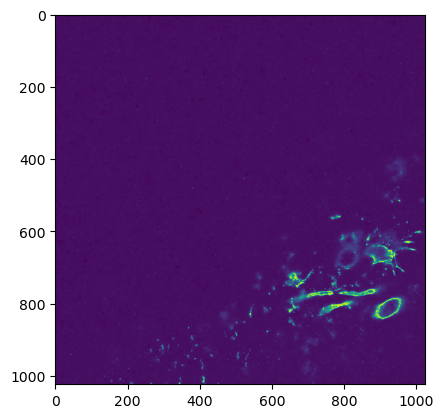

In [76]:
plt.imshow(one_preds[0,...,0])

600 600


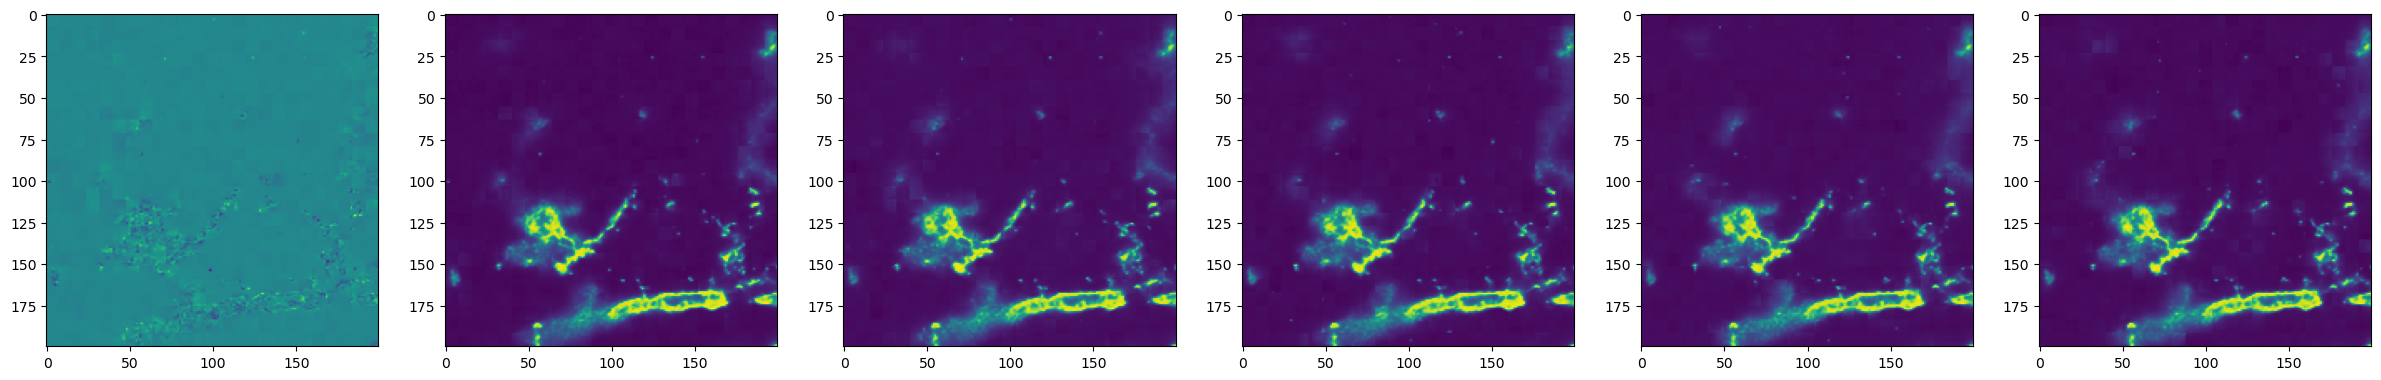

In [77]:
sz = 200
hs = 600#np.random.randint(0,one_preds.shape[1]-sz)
ws = 600#np.random.randint(0,one_preds.shape[2]-sz) 
print(hs,ws)
_,ax = plt.subplots(figsize=(30,5),ncols=6)
for i in range(1,6):
    ax[i].imshow(one_preds[i-1,hs:hs+sz,ws:ws+sz, 0])
ax[0].imshow(one_preds[1,hs:hs+sz,ws:ws+sz,0] - one_preds[0,hs:hs+sz,ws:ws+sz,0])

# Saving prediction

In [48]:
from denoisplit.core.tiff_reader import save_tiff
from denoisplit.data_loader.tumor_highres_rawdloader import get_train_val_filenames, get_train_val_data

fnames = get_train_val_filenames(data_dir, config.data, eval_datasplit_type, val_fraction=config.training.val_fraction, test_fraction=config.training.test_fraction)
data = get_train_val_data(data_dir, config.data, eval_datasplit_type, val_fraction=config.training.val_fraction, test_fraction=config.training.test_fraction)




Loaded from TwoChannel /media/lsdf02_VV/Ekin/Projects/ExM/VitalSynthEx/Data/forDivnoise/usplit/ 40



In [ ]:

unnorm_pred =  unnormalize_for_saving(pred)

In [50]:
assert data._data[0].shape[1:3] == pred.shape[1:3], 'Height and Width be better be the same.'
assert len(data) == len(pred)
start_idx = 0

for i, fsubpath in enumerate(fnames()):
    assert fsubpath[-4:] == '.tif', 'We only handle tiff files. Mi dispiache.'
    end_idx = start_idx + len(data._data[i])
    fpath = os.path.join(prediction_output_fpath, fsubpath)
    os.makedirs(os.path.dirname(fpath), exist_ok=True)

    save_tiff(fpath, pred[start_idx:end_idx])
    start_idx = end_idx

AssertionError: We only handle tiff files. Mi dispiache.

In [ ]:
pwd